# **Object Recognition**

## **Using Gradient Boosting**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar10

### **Loading CIFAR-10 Dataset**

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten label arrays to 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


### **Preprocessing CIFAR-10 Dataset**

Since Gradient Boosting expects flat feature vectors, we normalize the pixel values and flatten the images (from 32x32x3 to 3072).

In [4]:
# Normalize pixel values (0–1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Flattened training shape:", X_train_flat.shape)


Flattened training shape: (50000, 3072)


### **Reducing Dataset Size**

Gradient Boosting is computationally intensive. We use a smaller subset to speed up training.

In [5]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=10000, stratify=y_train, random_state=42)
X_test_sub, _, y_test_sub, _ = train_test_split(X_test_flat, y_test, train_size=2000, stratify=y_test, random_state=42)

print("Subset training shape:", X_train_sub.shape)
print("Subset test shape:", X_test_sub.shape)


Subset training shape: (10000, 3072)
Subset test shape: (2000, 3072)


### **Apply PCA for Dimensionality Reduction**

Images have 3072 features (32×32×3). PCA helps reduce it to a smaller number (like 100) while keeping most of the important information. This often helps reduce training time and can improve performance for tabular models like Gradient Boosting.

In [6]:
from sklearn.decomposition import PCA

# Apply PCA to training and testing data
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_sub)
X_test_pca = pca.transform(X_test_sub)

print("Original features:", X_train_sub.shape[1])
print("Reduced features after PCA:", X_train_pca.shape[1])


Original features: 3072
Reduced features after PCA: 100


### **Training Gradient Boosting on PCA-Reduced Data**

In [7]:
gb_pca = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_pca.fit(X_train_pca, y_train_sub)


GradientBoostingClassifier(random_state=42)

### **Evaluating the Gradient Boosting Model with PCA Reduced Dataset**

In [8]:
y_pred_pca = gb_pca.predict(X_test_pca)

print("Accuracy with PCA:", accuracy_score(y_test_sub, y_pred_pca))
print(classification_report(y_test_sub, y_pred_pca))


Accuracy with PCA: 0.4105
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       200
           1       0.49      0.45      0.47       200
           2       0.29      0.27      0.28       200
           3       0.27      0.24      0.26       200
           4       0.38      0.38      0.38       200
           5       0.37      0.29      0.32       200
           6       0.45      0.55      0.49       200
           7       0.40      0.39      0.39       200
           8       0.46      0.59      0.52       200
           9       0.43      0.47      0.45       200

    accuracy                           0.41      2000
   macro avg       0.41      0.41      0.41      2000
weighted avg       0.41      0.41      0.41      2000



### **Confusion Matrix With Reduced Dataset**

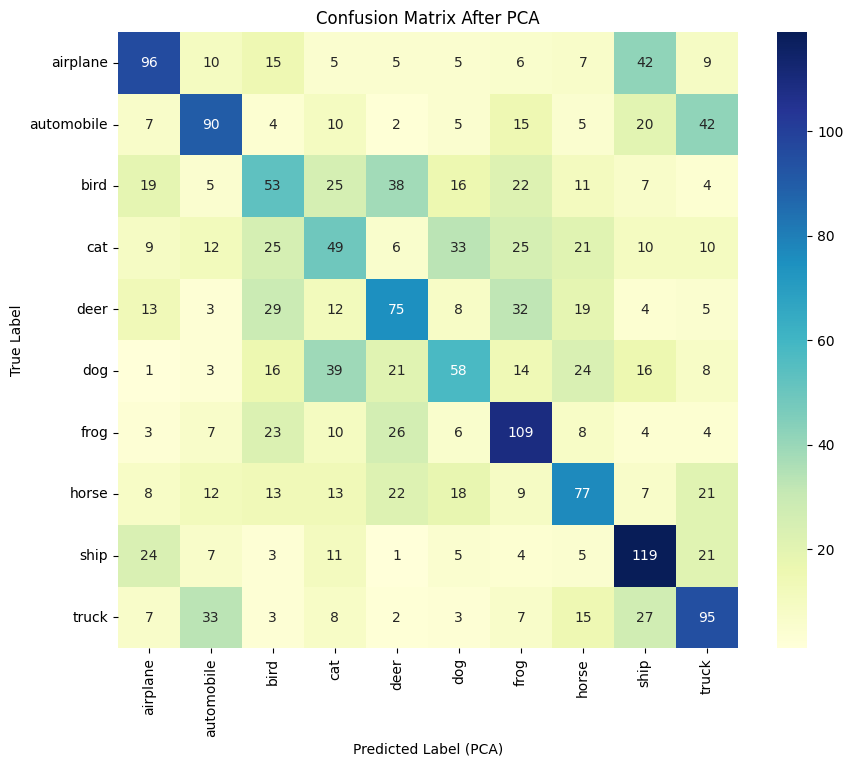

In [9]:
conf_mat_pca = confusion_matrix(y_test_sub, y_pred_pca)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_pca, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label (PCA)")
plt.ylabel("True Label")
plt.title("Confusion Matrix After PCA")
plt.show()


### **Function to Evaluate Parameter Variation**

We want to create a reusable function to evaluate how accuracy changes with different parameter values. This helps us visualize model behaviour.

In [10]:
from sklearn.metrics import accuracy_score
import time

def evaluate_param_variation(param_name, param_values, fixed_params, X_train, y_train, X_test, y_test):
    accuracies = []
    train_times = []

    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val

        model = GradientBoostingClassifier(**params)
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()

        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        accuracies.append(acc)
        train_times.append(end - start)

    return accuracies, train_times


In [11]:
# Use PCA-reduced data for tuning
X_train_plot = X_train_pca
X_test_plot = X_test_pca
y_train_plot = y_train_sub
y_test_plot = y_test_sub

# Base parameters for testing
base_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42
}


### **Accuracy vs Number of Estimators**

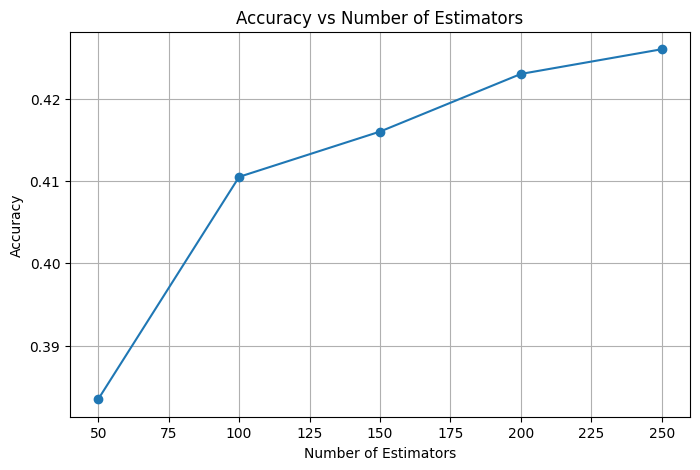

In [12]:
n_estimators_range = [50, 100, 150, 200, 250]
accs, times = evaluate_param_variation('n_estimators', n_estimators_range, base_params, X_train_plot, y_train_plot, X_test_plot, y_test_plot)

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, accs, marker='o')
plt.title("Accuracy vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


### **Accuracy vs Learning Rate**

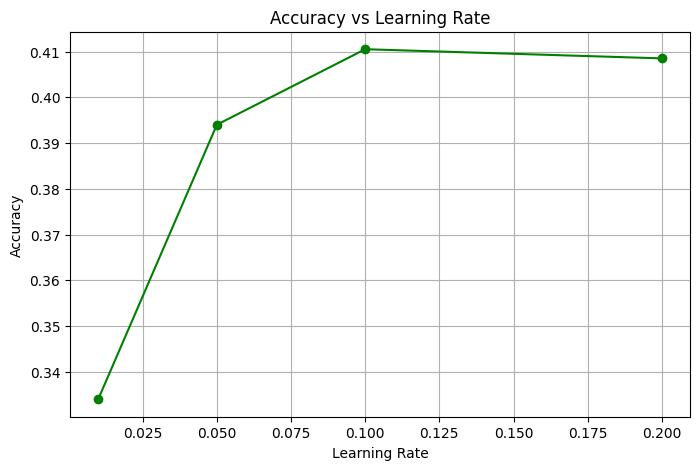

In [13]:
learning_rates = [0.01, 0.05, 0.1, 0.2]
accs, times = evaluate_param_variation('learning_rate', learning_rates, base_params, X_train_plot, y_train_plot, X_test_plot, y_test_plot)

plt.figure(figsize=(8, 5))
plt.plot(learning_rates, accs, marker='o', color='green')
plt.title("Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


### **Training time Comparision with learning rate**

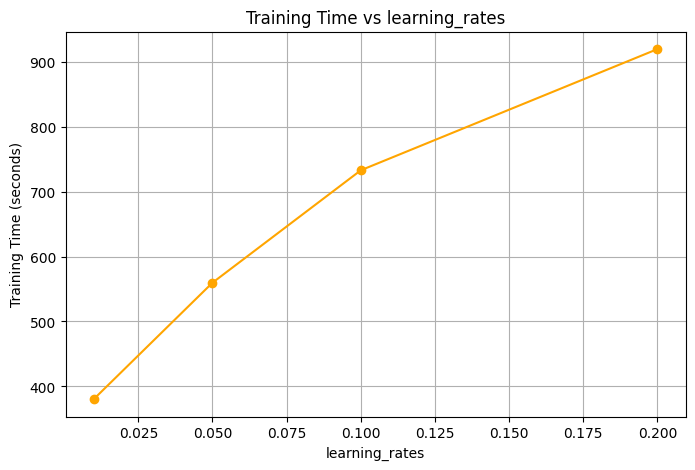

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, times, marker='o', color='orange')
plt.title("Training Time vs learning_rates")
plt.xlabel("learning_rates")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.show()

### **Accuracy vs Tree Depth**

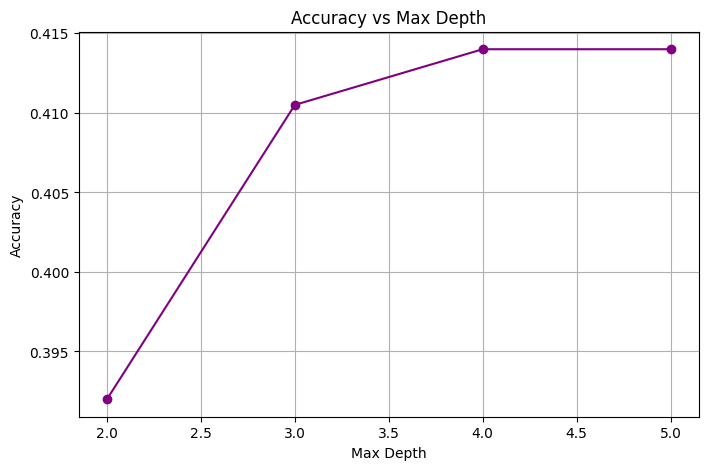

In [14]:
depths = [2, 3, 4, 5]
accs, times = evaluate_param_variation('max_depth', depths, base_params, X_train_plot, y_train_plot, X_test_plot, y_test_plot)

plt.figure(figsize=(8, 5))
plt.plot(depths, accs, marker='o', color='purple')
plt.title("Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


### **Adding Training Time Comparison**

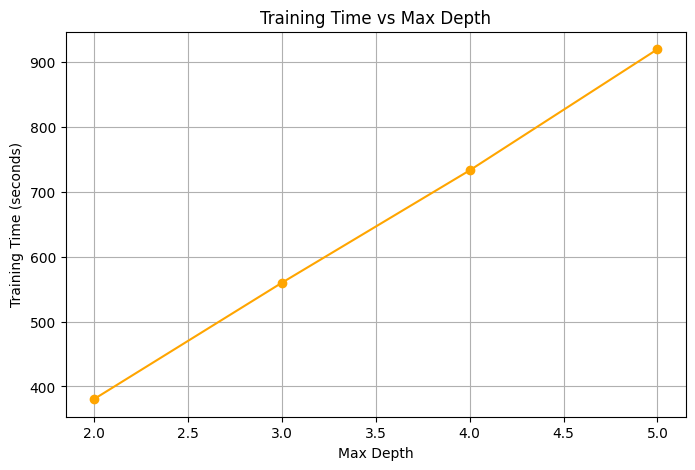

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(depths, times, marker='o', color='orange')
plt.title("Training Time vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.show()


### **Visualizing Gradient Boosting Predictions on CIFAR-10**

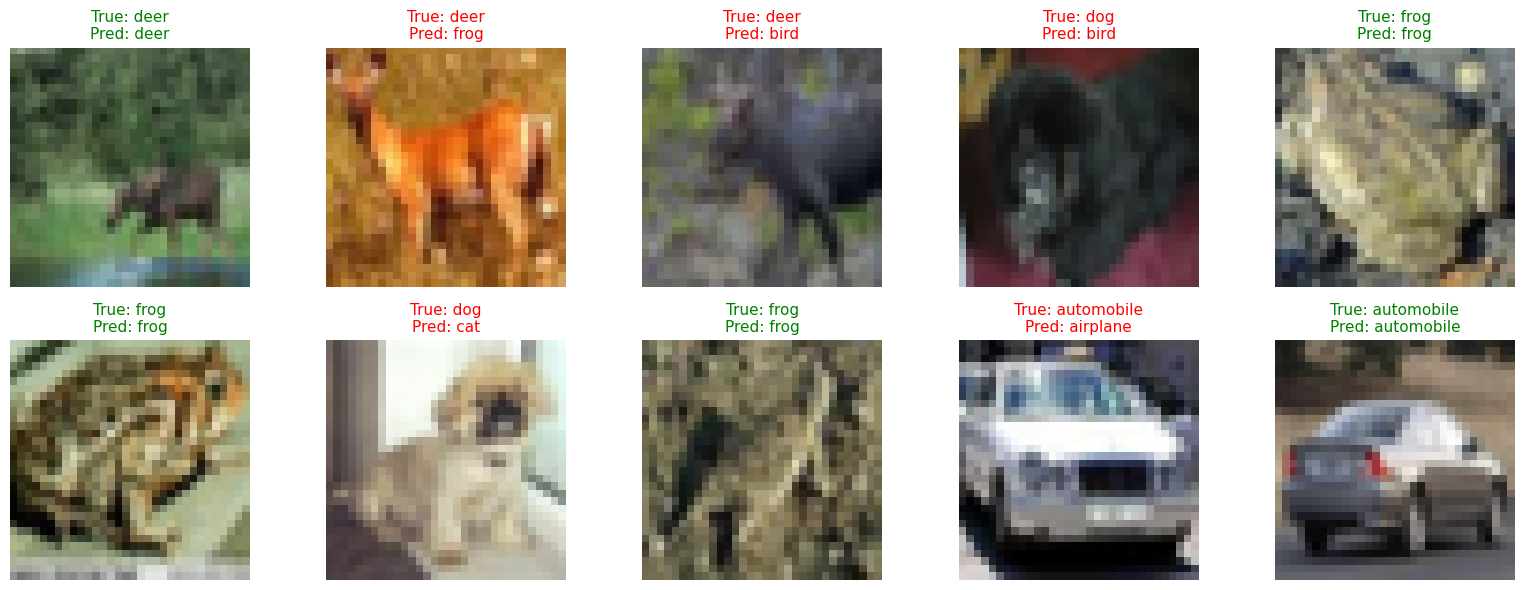

In [17]:
import random
# Select random indices to display
num_samples = 10
indices = random.sample(range(len(X_test_pca)), num_samples)

# Plot
plt.figure(figsize=(16, 6))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    # Get original image (not PCA) and reshape for display
    image = X_test_sub[idx].reshape(32, 32, 3)

    # Prediction info
    true_label = class_names[y_test_sub[idx]]
    pred_label = class_names[y_pred_pca[idx]]

    # Display image
    plt.imshow(image)
    plt.axis('off')

    # Color-coded title
    color = 'green' if true_label == pred_label else 'red'
    title_text = f"True: {true_label}\nPred: {pred_label}"
    plt.title(title_text, color=color, fontsize=11)

plt.tight_layout()
plt.show()